In [8]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [ ]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# Chargement et correction des données

Ce dataset est utilisé pour effectuer la prédiction de la température d'une pièce en fonction de plusieurs paramètres mesurés. La fréquence originale des données est d'une minute, puis a été modifiée à 15minutes avec un filtrage. L'ensemble correspond environ à une durée de 40 jours.  
Nous allons utiliser ici la température de la chambre comme cible et sélectionner 18 séries exogènes. 

**1. Chargement des données**

In [9]:
!rm *.csv
#!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/SML2010_RFE-CV.csv"
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/SMLselected_VSURF_pred.csv"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   189  100   189    0     0    570      0 --:--:-- --:--:-- --:--:--   570
100  109k  100  109k    0     0   147k      0 --:--:-- --:--:-- --:--:--  147k


**2. Analyse et correction des données**

In [10]:
# Création de la série sous Pandas
df_etude = pd.read_csv("SMLselected_VSURF_pred.csv")
df_etude

,Unnamed: 0,Temperature_Comedor_Sensor,7:CO2_Habitacion_Sensor,5:Weather_Temperature,9:Humedad_Habitacion_Sensor,Temperature_Habitacion_Sensor
0,0,18.1875,221.920,0.0000,42.4150,17.8275
1,1,18.4633,220.363,6.8000,42.2453,18.1207
2,2,18.7673,218.933,17.0000,42.2267,18.4367
3,3,19.0727,217.045,18.0000,42.0987,18.7513
4,4,19.3721,216.080,20.0000,42.0686,19.0414
...,...,...,...,...,...,...
2759,2759,21.1520,192.181,13.0000,41.6880,20.8187
2760,2760,21.0413,193.067,12.1333,41.7200,20.7053
2761,2761,20.9347,193.653,12.0000,41.7573,20.5827
2762,2762,20.8560,193.387,12.0000,41.8107,20.5200


In [11]:
df_etude = df_etude.drop(['Unnamed: 0'],axis=1)
df_etude

,Temperature_Comedor_Sensor,7:CO2_Habitacion_Sensor,5:Weather_Temperature,9:Humedad_Habitacion_Sensor,Temperature_Habitacion_Sensor
0,18.1875,221.920,0.0000,42.4150,17.8275
1,18.4633,220.363,6.8000,42.2453,18.1207
2,18.7673,218.933,17.0000,42.2267,18.4367
3,19.0727,217.045,18.0000,42.0987,18.7513
4,19.3721,216.080,20.0000,42.0686,19.0414
...,...,...,...,...,...
2759,21.1520,192.181,13.0000,41.6880,20.8187
2760,21.0413,193.067,12.1333,41.7200,20.7053
2761,20.9347,193.653,12.0000,41.7573,20.5827
2762,20.8560,193.387,12.0000,41.8107,20.5200


Affiche les types :

In [12]:
df_etude.dtypes

Temperature_Comedor_Sensor       float64
7:CO2_Habitacion_Sensor          float64
5:Weather_Temperature            float64
9:Humedad_Habitacion_Sensor      float64
Temperature_Habitacion_Sensor    float64
dtype: object

Modifie les type en float32 :

In [13]:
df_etude = df_etude.astype(dtype='float32')
df_etude.dtypes

Temperature_Comedor_Sensor       float32
7:CO2_Habitacion_Sensor          float32
5:Weather_Temperature            float32
9:Humedad_Habitacion_Sensor      float32
Temperature_Habitacion_Sensor    float32
dtype: object

**5. Affiche les données**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['Temperature_Habitacion_Sensor'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Séparation des données de test et d'entrainement

In [14]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 2211
Taille de la validation : 553


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [15]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [16]:
print(serie_entrainement_X_norm.shape)
print(serie_test_X_norm.shape)

(2211, 5)
(553, 5)


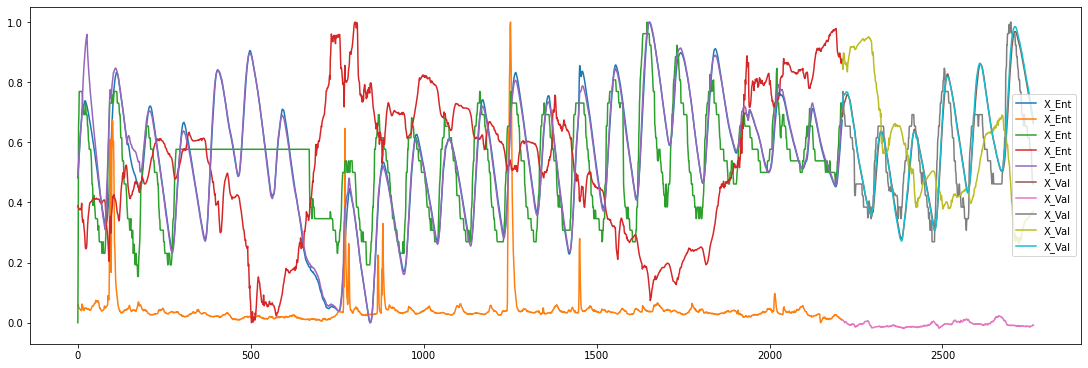

In [17]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création des datasets

Les datasets sont créés de la manière suivante :

  <img src='https://raw.githubusercontent.com/AlexandreBourrieau/FICHIERS/main/Series_Temporelles/Multi/images/DatasetDARNN.bmp' width=500/>

**1. Exemple de dataset**

In [18]:
X1 = np.linspace(1,100,100)
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100)

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

Serie_X = tf.concat([X1,X2,X3],axis=1)
Serie_Y = Y
print(Serie_X.shape)

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),((X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT-1)}
# Y = YT

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence-1][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

test_dataset = prepare_dataset_XY(Serie_X,Serie_Y,10,1,1,1)

print(len(list(test_dataset.as_numpy_iterator())))
for element in test_dataset.take(1):
  print(element)

(100, 3)
90
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  1., 101., 201.],
        [  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.]]])>, <tf.Tensor: shape=(1, 9, 1), dtype=float64, numpy=
array([[[301.],
        [302.],
        [303.],
        [304.],
        [305.],
        [306.],
        [307.],
        [308.],
        [309.]]])>), <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[310.]]])>)


**2. Préparation des datasets**

In [19]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT-1)}
# Y = YT

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence-1][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [20]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 10
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [21]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT-1)
  print(element[1].shape)               # YT

17
(128, 10, 4)
(128, 9, 1)
(128, 1, 1)


In [22]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT-1
  print(element[1].shape)               # YT

4
(128, 10, 4)
(128, 9, 1)
(128, 1, 1)


**3. Préparation des X/Y**

In [23]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(2176, 10, 4)
(2176, 9, 1)
(2176, 1, 1)


In [24]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(512, 10, 4)
(512, 9, 1)
(512, 1, 1)


# Affichage des séries

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(np.linspace(0,longueur_sequence,longueur_sequence),x_train[0][0,:,0:3],label="X_train (X)")
ax.plot(np.linspace(0,longueur_sequence-1,longueur_sequence-1),x_train[1][0,:,:],label="X_train (Y)")

ax.plot(np.linspace(longueur_sequence,longueur_sequence+1,1),y_train[0,:,:],label="Y_train",marker="*")

ax.legend()
plt.show()

# Création du modèle DA-RNN2

Le modèle DA-RNN implanté est le suivant :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/DARNN_VueEnsemble.png?raw=true'>

**1. Création de la couche du calcul des scores de l'encodeur**

Cette fonction calcule le score de l'encodeur, c'est-à-dire le score à attribuer à chaque série d'entrée.  
Cette fonction est appellée par l'encodeur à l'aide de la méthode TimeDistribued de Keras, pour chaque série d'entrée.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/DARNN_CalculScore.png?raw=true' width=900>

In [25]:
class CalculScores_Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM):
    self.dim_LSTM = dim_LSTM
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.We = self.add_weight(shape=(input_shape[1],2*self.dim_LSTM),initializer="normal",name="We")    # (Tin, 2x#LSTM)
    self.Ue = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="Ue")     # (Tin, Tin)
    self.be = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="be")                  # (Tin, 1)
    self.ve = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="ve")                  # (Tin, 1)
    super().build(input_shape)        # Appel de la méthode build()
    
  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)

  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)]
  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,1)
  # Sorties :
  #     score:          Score               : (batch_size,1,1)
  def call(self, input):
    if self.hidd_state is not None:
        hs = tf.keras.layers.concatenate([self.hidd_state,self.cell_state],axis=1)        # (batch_size,2x#LSTM)
        hs = tf.expand_dims(hs,-1)                                              # (batch_size,2x#LSTM) => (batch_size,2#LSTM,1)
        e = tf.matmul(self.We,hs)                                               # (Tin,2x#LSTM)x(batch_size,2x#LSTM,1) = (batch_size,Tin,1)
        e = e + tf.matmul(self.Ue,input)                                        # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.be                                                         # (batch_size,Tin,1)
    else:
        e = tf.matmul(self.Ue,input)                                            # (Tin,Tin)x(batch_size,Tin,1) = (batch_size,Tin,1)
        e = e + self.be                                                         # (batch_size,Tin,1)
    e = K.tanh(e)
    score = tf.matmul(tf.transpose(self.ve),e)                                  # (1,Tin)x(batch_size,Tin,1) = (batch_size,1,1)
    return tf.squeeze(score,-1)                                                 # (batch_size,1)

**2. Création de la couche d'encodeur à base de LSTM**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Modif.png?raw=true' width=900>

In [26]:
class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM          # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Encodeur")
    self.couche_CalculScores_Encodeur = CalculScores_Encodeur(dim_LSTM=self.dim_LSTM)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)]
  #     index:          index série         : (1)
  # Sorties :
  #     out_hid : Sortie vecteur caché      : (batch_size,#LSTM)
  #     out_cell: Sortie cell state         : (btach_size,#LSTM)
  def call(self, input, hidd_state, cell_state, index):
    # Calcul des scores
    input_TD = tf.transpose(input,perm=[0,2,1])                               # (batch_size,Tin,#dim) => (batch_size,#dim,Tin)
    input_TD = tf.expand_dims(input_TD,axis=-1)                               # (batch_size,#dim,Tin) => (batch_size,#dim,Tin,1)
    self.couche_CalculScores_Encodeur.SetStates(hidd_state,cell_state)
    a = tf.keras.layers.TimeDistributed(
        self.couche_CalculScores_Encodeur)(input_TD)                          # (batch_size,#dim,Tin,1) : Timestep=#dim
                                                                              # (batch_size,Tin,1) envoyé #dim fois en //
                                                                              # (batch_size,#dim,1) retourné
    # Normalisation des scores
    a = tf.keras.activations.softmax(a,axis=1)                                # (batch_size,#dim,1)

    # Applique les poids normalisés à la série
    x_tilda = tf.multiply(tf.expand_dims(input[:,index,:],-1),a)              # (batch_size,#dim,1) _x_ (batch_size,#dim,1) = (batch_size,#dim,1)
    x_tilda = tf.transpose(x_tilda,perm=[0,2,1])                              # (batch_size,1,#dim)

    # Applique x_tilda à la cellule LSTM
    x_tilda = tf.transpose(x_tilda,perm=[0,2,1])                              # (batch_size,#dim,1)
    out_dec, out_hid, out_cell = self.couche_LSTM(x_tilda)                    # out_dec et out_cell : (batch_size,#LSTM)

    return out_hid, out_cell


**2. Création de la couche d'attention du décodeur**

On commence par créer la couche de calcul du score du décodeur.  
Cette fonction calcule le score du décodeur, c'est-à-dire le score à attribuer à chaque hidden-state en sortie de l'encodeur.  
Cette fonction est appellée par la couche d'attention temporelle du décodeur à l'aide de la méthode TimeDistribued de Keras.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/DARNN_CalculScoreAttention2.png?raw=true' width=900>

In [27]:
class CalculScores_Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_LSTM):
    self.dim_LSTM = dim_LSTM            # Dimension des vecteurs cachés
    super().__init__()                  # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wd = self.add_weight(shape=(self.dim_LSTM,2*self.dim_LSTM),initializer="normal",name="Wd")     # (#LSTM, 2x#LSTM)
    self.Ud = self.add_weight(shape=(self.dim_LSTM,self.dim_LSTM),initializer="normal",name="Ud")       # (#LSTM, #LSTM)
    self.bd = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bd")                   # (#LSTM, 1)
    self.vd = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="vd")                   # (#LSTM, 1)
    super().build(input_shape)        # Appel de la méthode build()

  def compute_output_shape(self, input_shape):
    return (input_shape[0], 1)


  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)
  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:        Entrée décodeur       : (batch_size,#LSTM)
  # Sorties :
  #     v_contexte:   vecteur contexte      : (batch_size,#LSTM)
  def call(self,input):
    input = tf.expand_dims(input,-1)
    if self.hidd_state is not None:
        hs = tf.keras.layers.concatenate([self.hidd_state,self.cell_state],axis=1)        # (batch_size,2x#LSTM)
        hs = tf.expand_dims(hs,-1)                                              # (batch_size,2x#LSTM) => (batch_size,2#LSTM,1)
        e = tf.matmul(self.Wd,hs)                                               # (#LSTM,2x#LSTM)x(batch_size,2x#LSTM,1) = (batch_size,#LSTM,1)
        e = e + tf.matmul(self.Ud,input)                                        # (#LSTM,#LSTM)x(batch_size,#LSTM,1) = (batch_size,#LSTM,1)
        e = e + self.bd                                                         # (batch_size,#LSTM,1)
    else:
        e = tf.matmul(self.Ud,input)                                            # (#LSTM,#LSTM)x(batch_size,#LSTM,1) = (batch_size,#LSTM,1)
        e = e + self.bd                                                         # (batch_size,#LSTM,1)
    e = K.tanh(e)
    score = tf.matmul(tf.transpose(self.vd),e)                                  # (1,#LSTM)x(batch_size,#LSTM,1) = (batch_size,1,1)
    score = tf.squeeze(score,-1)                                                # (batch_size,1)
    return score

Puis maintenant la couche d'attention :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/DARNN_CalculAttentionDecodeur.png?raw=true' width=900>

In [28]:
class CalculAttention_Decodeur(tf.keras.layers.Layer):
  def __init__(self, dim_LSTM):
    self.dim_LSTM = dim_LSTM          # Dimension des vecteurs cachés
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_CalculScores_Decodeur = CalculScores_Decodeur(dim_LSTM=self.dim_LSTM)
    super().build(input_shape)        # Appel de la méthode build()

  #     hidd_state:     hidden_state        : (batch_size,#LSTM)
  #     cell_state:     Cell state          : (batch_size,#LSTM)
  def SetStates(self,hidd_state, cell_state):
    self.hidd_state = hidd_state
    self.cell_state = cell_state

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#LSTM)
  # Sorties :
  #     vect_contexte   Vecteur Contexte    : (batch_size,1,#LSTM)
  def call(self, input):
    # Calcul des scores
    self.couche_CalculScores_Decodeur.SetStates(self.hidd_state,self.cell_state)
    b = tf.keras.layers.TimeDistributed(
        self.couche_CalculScores_Decodeur)(input)                             # (batch_size,Tin,#LSTM) : Timestep=Tin
                                                                              # (batch_size,#LSTM) envoyé Tin fois en //
                                                                              # (batch_size,Tin,1) retourné
    # Normalisation des scores
    b = tf.keras.activations.softmax(b,axis=1)                                # (batch_size,Tin,1)

    # Calcul du vecteur contexte
    C = tf.multiply(input,b)        # (batch_size,Tin,#LSTM)_x_(batch_size,Tin,1) = (batch_size,Tin,#LSTM)
    C = K.sum(C,axis=1)             # (batch_size,#LSTM)
    C = tf.expand_dims(C,1)         # (batch_size,1,#LSTM)
    return C


**3. Création de la couche de décodeur**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/DARNN_Decodeur.png?raw=true'>

In [29]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_LSTM, regul=0.0, drop=0.0):
    self.regul = regul
    self.dim_LSTM = dim_LSTM            # Dimension des vecteurs cachés
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_Attention_Decodeur = CalculAttention_Decodeur(dim_LSTM=self.dim_LSTM)
    self.couche_LSTM = tf.keras.layers.LSTM(self.dim_LSTM,kernel_regularizer=tf.keras.regularizers.l2(self.regul),return_sequences=False,return_state=True,dropout=self.drop,recurrent_dropout=self.drop, name="LSTM_Decodeur")
    self.W = self.add_weight(shape=(self.dim_LSTM+1,1),initializer="normal",name="W")                   # (#LSTM+1, 1)
    self.b = self.add_weight(shape=(1,1),initializer="normal",name="b")                                 # (1, 1)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:        Entrée décodeur       : (batch_size,Tin,#LSTM)
  #     Y:            Yt                    : (batch_size,1,1)
  #     hid_state:    hidden state          : (batch_size,#LSTM)
  #     cell_state:   cell_state            : (batch_size,#LSTM)
  # Sorties :
  #     out_hid :     hidden_state          : (batch_size,#LSTM)
  #     out_cell :    cell_state            : (batch_size,#LSTM)
  #     v_contexte:   vecteur contexte      : (batch_size,#LSTM)
  def call(self,input,Y,hid_state,cell_state):
    # Calcul du vecteur contexte
    self.couche_Attention_Decodeur.SetStates(hid_state,cell_state)
    C = self.couche_Attention_Decodeur(input)           # (batch_size,1,#LSTM)

    # Calcul de Y_tilda
    add = tf.keras.layers.concatenate([Y,C],axis=2)     # (batch_size,1,#LSTM+1)
    add = tf.transpose(add,perm=[0,2,1])                # (batch_size,#LSTM+1,1)
    Y_tilda = tf.matmul(tf.transpose(self.W),add)       # (1,#LSTM+1) x (batch_size,#LSTM+1,1) = (batch_size,1,1)
    Y_tilda = Y_tilda + self.b

    # Calcul des hidden state et cell state
    if hid_state is not None:
      out_, out_hid, out_cell = self.couche_LSTM(Y_tilda,initial_state=[hid_state,cell_state])
    else:
      out_, out_hid, out_cell = self.couche_LSTM(Y_tilda)

    return out_hid,out_cell, C

**4. Création de la couche réseau**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/DARNN_VueEnsemble.png?raw=true'>

In [30]:
class Net_DARNN(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, dim_LSTM, regul=0.0, drop = 0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.regul = regul
    self.drop = drop
    self.dim_LSTM = dim_LSTM
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wy = self.add_weight(shape=(self.dim_LSTM,2*self.dim_LSTM),initializer="normal",name="Wy")     # (#LSTM, 2x#LSTM)
    self.bw = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="bw")                   # (#LSTM, 1)
    self.vy = self.add_weight(shape=(self.dim_LSTM,1),initializer="normal",name="vy")                   # (#LSTM, 1)
    self.bv = self.add_weight(shape=(1,1),initializer="normal",name="bv")                               # (1, 1)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     output_seq:     Sortie séquence Y   : (batch_size,Tin-1,1)
  # Sorties :
  #     sortie:         Prédiction Y        : (batch_size,1,1)
  def call(self,input,output_seq):
    # Phase d'encodage
    # Calcul les représentations cachées spatialles
    # des séries en entrée
    hid = []
    hid_state = None
    cell_state = None
    for i in range(input.shape[1]):
      hid_state, cell_state = self.encodeur(input,hid_state,cell_state,i)
      hid.append(hid_state)
    hid = tf.convert_to_tensor(hid)               # (Tin,batch_size,#LSTM)
    hid = tf.transpose(hid,perm=[1,0,2])          # (batch_size,Tin,#LSTM)

    # Phase de décodage
    # Calcul du vecteur contexte de sortie et du dernier
    # hidden state à partir des représentations cachées
    # précédentes et des (T-1) premieres sortie Y
    hid_, cell_, vc = self.decodeur(hid,output_seq[:,0:1,:]*0,None,None)
    for i in range(0,output_seq.shape[1]):
      hid_, cell_, vc = self.decodeur(hid,output_seq[:,i:i+1,:],hid_,cell_)
    
    # Estimation de la sortie
    # hid_ : (batch_size,#LSTM)
    # vc   : (batch_size,1,#LSTM)
    add = tf.keras.layers.concatenate([tf.expand_dims(hid_,1),vc],axis=2)       # (batch_size,1,2x#LSTM)
    add = tf.transpose(add,perm=[0,2,1])                                        # (batch_size,2x#LSTM,1)
    sortie = tf.matmul(self.Wy,add)                                             # (#LSTM,2x#LSTM) x (batch_size,2x#LSTM+1,1) = (batch_size,#LSTM,1)
    sortie = sortie + self.bw                                                   # (batch_size,#LSTM,1)
    sortie = tf.matmul(tf.transpose(self.vy),sortie)                            # (1,#LSTM)x(batch_size,#LSTM,1) = (batch_size,1,1)
    sortie = sortie + self.bv                                                   # (batch_size,1,1)
    return sortie

**4. Création du modèle**

In [31]:
dim_LSTM = 128
drop=0.0
l2reg=0.0

def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]))
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence-1,1))

  encodeur = Encodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)
  decodeur = Decodeur(dim_LSTM=dim_LSTM,drop=drop,regul=l2reg)

  sortie = Net_DARNN(encodeur,decodeur,longueur_sequence=longueur_sequence,dim_LSTM=dim_LSTM,regul=l2reg,drop=drop)(entrees_sequences,sorties_sequence)

  model = tf.keras.Model([entrees_sequences,sorties_sequence],sortie)
  return model

# Entrainement avec TPU

In [32]:
  from google.colab import files

  max_periodes = 500


  model = get_model()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.001)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)],batch_size=batch_size)

  files.download('poids_train.hdf5')

Epoch 1/500
17/17 [==============================] - 41s 533ms/step - loss: 0.1672 - mse: 0.1672 - val_loss: 0.0285 - val_mse: 0.0285

Epoch 00001: loss improved from inf to 0.16718, saving model to poids_train.hdf5
Epoch 2/500
17/17 [==============================] - 2s 103ms/step - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0254 - val_mse: 0.0254

Epoch 00002: loss improved from 0.16718 to 0.04352, saving model to poids_train.hdf5
Epoch 3/500
17/17 [==============================] - 2s 102ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0210 - val_mse: 0.0210

Epoch 00003: loss improved from 0.04352 to 0.03575, saving model to poids_train.hdf5
Epoch 4/500
17/17 [==============================] - 2s 103ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0106 - val_mse: 0.0106

Epoch 00004: loss improved from 0.03575 to 0.02557, saving model to poids_train.hdf5
Epoch 5/500
17/17 [==============================] - 2s 103ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0051 - val_mse: 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

max_periodes = 500

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.01,
      decay_steps=50,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)],batch_size=batch_size)

files.download('poids_train.hdf5')

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train[0],x_train[1]],y=y_train)
model.evaluate(x=[x_val[0],x_val[1]],y=y_val)

# Chargement du modèle pré-entrainé

**DA-RNN2_10_SML2010-SELECTED**  

  - Vecteur LSTM : 128  
  - Longueur entrée : 10  
  - Longueur sortie : 1
  - Drop : 0.0
  - L2 : 0.00  
  - Batch Size : 128  
  - Périodes : 500   
  - Features : RFE-CV  
	=> mse :  2.1753e-05 / 9.4624e-06
  
  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/TrainDARNN_2.png?raw=true' width=500/>

In [ ]:
model = get_model()

In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Models/DA-RNN2_10_SML2010-SELECTEDRFECV.hdf5"

In [ ]:
model.load_weights("DA-RNN2_10_SML2010-SELECTEDRFECV.hdf5")

# Prédictions single-step

In [ ]:
pred_ent = model.predict([x_train[0],x_train[1]],verbose=1)
pred_val = model.predict([x_val[0],x_val[1]],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
print(mse_ent)
print(mse_test)

# Exportation des résultats

In [ ]:
#Prédictions sur l'entrainement
pred_entrainement = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred_entrainement.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred_entrainement = tf.convert_to_tensor(pred_entrainement).numpy()
pred_entrainement = np.reshape(pred_entrainement,(pred_entrainement.shape[0]*pred_entrainement.shape[1]))

#Prédictions sur les validations
pred_validation = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred_validation.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred_validation = tf.convert_to_tensor(pred_validation).numpy()
pred_validation = np.reshape(pred_validation,(pred_validation.shape[0]*pred_validation.shape[1]))

In [ ]:
df_DARNN_Ent = pd.DataFrame(data=pred_entrainement,columns=['Pred_Ent'])
df_DARNN_Val = pd.DataFrame(data=pred_validation,columns=['Pred_Val'])

In [ ]:
df_DARNN_Ent.to_csv("df_DARNN2_SML2010_Ent.csv")
df_DARNN_Val.to_csv("df_DARNN2_SML2010_Val.csv")

In [ ]:
files.download("df_DARNN2_SML2010_Val.csv")

# Prédictions naïves

Mettons en place un modèle qui effectue des prédictions naïves :

In [ ]:
class Net_Naif(tf.keras.layers.Layer):
  def __init__(self,longueur_sequence):
    self.longueur_sequence = longueur_sequence
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Sortie séquence Y   : (batch_size,1,1)
  # Sorties :
  #     sortie:   Prédiction Y        : (batch_size,1,1)
  def call(self,input):
    return tf.expand_dims(input[:,-1:,:],-1)                  # (batch_size,1,1)

In [ ]:
def get_model():
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence-1,1))
  sortie = Net_Naif(longueur_sequence=longueur_sequence)(sorties_sequence)
  model = tf.keras.Model(sorties_sequence,sortie)
  return model

In [ ]:
model_naif = get_model()

In [ ]:
pred_ent = model_naif.predict(x_train[1],verbose=1)
pred_val = model_naif.predict(x_val[1],verbose=1)

In [ ]:
model_naif.compile(loss="mse")
model_naif.evaluate(x=x_train[1],y=y_train)
model_naif.evaluate(x=x_val[1],y=y_val)

Ent : loss: 1.1171e-04  
Val : loss: 8.9610e-05

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()